In [536]:
import pandas as pd
import numpy as np

In [537]:
%matplotlib inline
import matplotlib.pylab as plt

### Make plots bigger

In [538]:
import seaborn as sns
sns.set(rc={'figure.figsize':(20.7,8.27)})

In [539]:
from pdkit.gait_time_series import GaitTimeSeries
from pdkit.gait_processor import GaitProcessor
from pdkit.utils import butter_lowpass_filter

In [540]:
import scipy.signal as sig
import pywt

In [541]:
clean_data = '/src/data/pdkit/GAIT_-_2018-06-14_13-50-58_-_d90b653403_-_13311.csv'

In [543]:
gd = GaitTimeSeries.load_data(clean_data, format_file='gait_gyro')

Sampling rate is 499.6666666666667 samples / second


In [544]:
gd

,x,y,z,r1,r2,r3,mag_sum_acc,td
1970-01-01 00:00:00.000,6.988888,7.869981,3.304099,0.181872,-0.873013,-0.016466,11.031692,0.000
1970-01-01 00:00:00.002,7.075082,7.944204,3.368745,0.178818,-0.916995,-0.010357,11.158656,0.002
1970-01-01 00:00:00.004,7.137333,8.080677,3.421419,0.188592,-1.012290,-0.006692,11.311276,0.004
1970-01-01 00:00:00.006,7.300144,8.281796,3.593807,0.193479,-1.109418,-0.007914,11.610155,0.006
1970-01-01 00:00:00.008,7.300144,8.281796,3.593807,0.196533,-1.156455,-0.009746,11.610155,0.008
1970-01-01 00:00:00.010,7.357606,8.442213,3.730280,0.210583,-1.253582,-0.012190,11.803403,0.010
1970-01-01 00:00:00.012,7.434223,8.616995,3.869148,0.226465,-1.339714,-0.023185,12.020423,0.012
1970-01-01 00:00:00.014,7.467743,8.703189,3.948159,0.231963,-1.378199,-0.027461,12.128505,0.014
1970-01-01 00:00:00.016,7.527600,8.875577,4.103787,0.255176,-1.450892,-0.040900,12.340247,0.016
1970-01-01 00:00:00.018,7.544360,8.954588,4.163644,0.268615,-1.478992,-0.049453,12.427306,0.018


In [13]:
gp = GaitProcessor(sampling_frequency=100.0, filter_order=4, cutoff_frequency=2.0)

In [14]:
d = gp.resample_signal(gd)

Sampling rate is 100.0 samples / second


## Let's have a look at the acceleration data

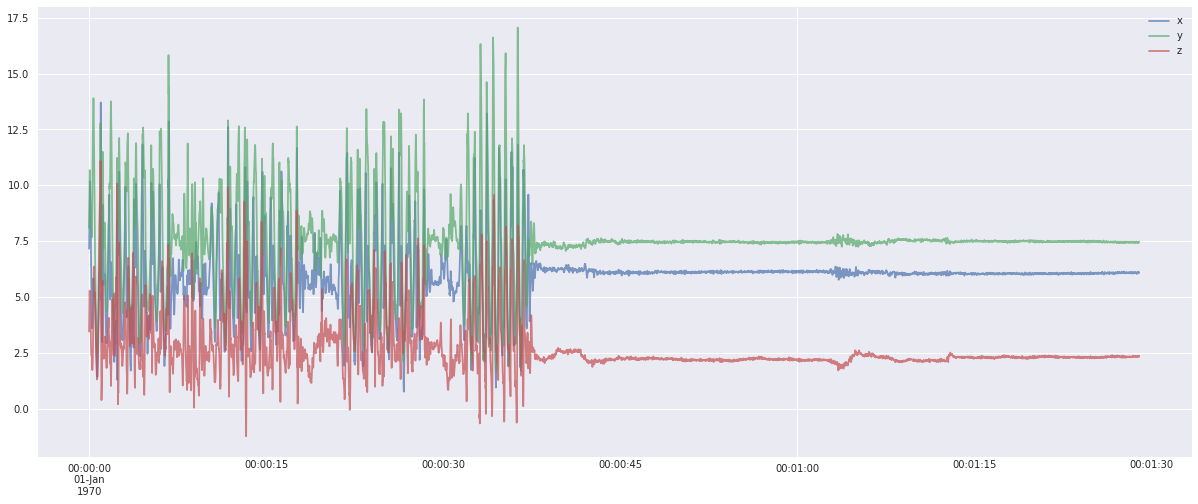

In [15]:
d[['x', 'y', 'z']].plot(alpha=0.7)

First of all we need to filter the data because it is too noisy. We will use a lowpass bandpass filter, as this type of data cleaning yelded the best results.

There is a new function inside the ``Processor``  that will filter the entire dataframe, and it uses the following variables:

``gp = GaitProcessor(sampling_frequency=100.0, filter_order=4, cutoff_frequency=2.0)``

We have to provide the ``sampling_frequency``, ``filter_order`` and ``cutoff_frequency``, afterwards we can just call ``gp.filter_data_frame()`` and it will return a filtered dataframe on all axes.

In [16]:
df = gp.filter_data_frame(d)

Let's see how the signal looks now...

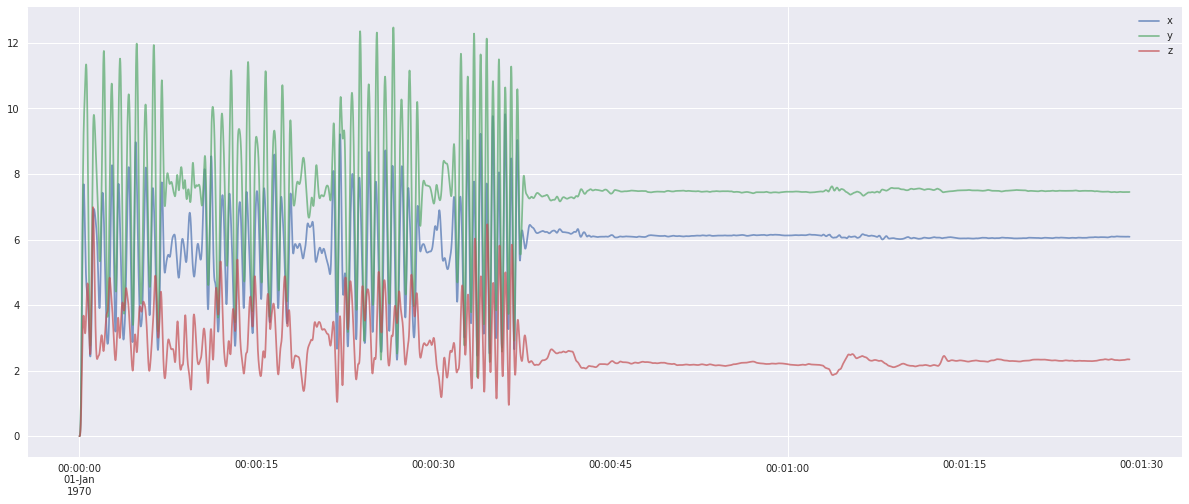

In [17]:
df[['x', 'y', 'z']].plot(alpha=0.7)

Ok, the data looks better now but we still need to figure out where actual walking stops and extract the interesting part of the signal.

We now need to separate walking from turning and section these into walks and turns.

To achieve this we will use k-means clustering on the prominences.

We will also use a smoothing window to correct for the missclassification that k-means clustering is prone to. The window functionality if very simple, it will take in 3 parameters of the form [border, smoothing, border], where each parameter represents the number of elemets to look at in the window. This will run a sliding window of form [border, smoothing, border] on the signal and if the border elements are the same it will change the smooth elements to match the border.

An example:

A window of form [2, 1, 2], has the first border made out of two element, the smoothing only one element and the second border two. This windo will slide over any signal and output 5 elements every time.

If this window outputs [1, 1, 0, 1, 1], than it will automatically change it to [1, 1, 1, 1, 1] as both the borders match.

If it outputs [1, 1, 0, 0, 1] it will do nothing as the borders do not match.

So if the border elements match it will transform the middle (smoothing) into the same as the border. This is quite intuitive as it focuses on neighbours in the signal, if we have something that is missclassified it will more likely be sorounded by other classes.

In [588]:
import scipy.signal as sig
from scipy.cluster.vq import kmeans, vq, kmeans2

def cluster_walk_turn(data, window=[1, 1, 1]):
    """ This will use k-means clustering to separate walking from turning. It will do clustering on the
        peaks prominences as it is quite evident that for walking these are considerably larger than for
        turning.
        
        :param data array: One-dimensional array.
        :param window array: This is a smoothing functionality so we can fix misclassifications.
                             It will run a sliding window of form [border, smoothing, border] on the
                             signal and if the border elements are the same it will change the 
                             smooth elements to match the border. An example would be for a window
                             of [2, 1, 2] we have the following elements [1, 1, 0, 1, 1], this will
                             transform it into [1, 1, 1, 1, 1]. So if the border elements match it
                             will transform the middle (smoothing) into the same as the border.
                             
        :return clusters array: One big array which match every peak to a class (0 and 1).
        :return peaks array: The peaks of our data.
        :return prominences array: The prominences of the peaks.
    """
    peaks, _ = sig.find_peaks(data)
    prominences = sig.peak_prominences(data, peaks)[0]
    
    # we use 2 clusters because we care about walking and turning only
    codebook, _ = kmeans(prominences, [prominences.max(), prominences.min()])
    clusters, _ = vq(prominences, codebook)
    
    # NOTE: need to think more about this...
    if window:
        clusters = smoothing_window(clusters, window=window)
        
    return clusters, peaks, prominences

def smoothing_window(data, window=[1, 1, 1]):
    """ This is a smoothing functionality so we can fix misclassifications.
        It will run a sliding window of form [border, smoothing, border] on the
        signal and if the border elements are the same it will change the 
        smooth elements to match the border. An example would be for a window
        of [2, 1, 2] we have the following elements [1, 1, 0, 1, 1], this will
        transform it into [1, 1, 1, 1, 1]. So if the border elements match it
        will transform the middle (smoothing) into the same as the border.
        
        :param data array: One-dimensional array.
        :param window array: Used to define the [border, smoothing, border]
                             regions.
                             
        :return data array: The smoothed version of the original data.
    """
    
    for i in range(len(data) - sum(window)):
        
        start_window_from = i
        start_window_to = i+window[0]

        end_window_from = start_window_to + window[1]
        end_window_to = end_window_from + window[2]

        if np.all(data[start_window_from: start_window_to] == data[end_window_from: end_window_to]):
            data[start_window_from: end_window_to] = data[start_window_from]
            
    return data

Let's create a function that will help us plot all the peaks, prominences and clusters, so we can check if the clustering worked.

In [591]:
def plot_walk_turn_clusters(data, window=[1, 1, 1]):
    c, pk, p = cluster_walk_turn(data, window=window)
    
    contour_heights = data[pk] - p
    
    colors = [['red', 'green'][i] for i in c]
    plt.plot(data)
    plt.scatter(pk, data[pk], color=colors)
    plt.vlines(x=pk, ymin=contour_heights, ymax=data[pk], color=colors)

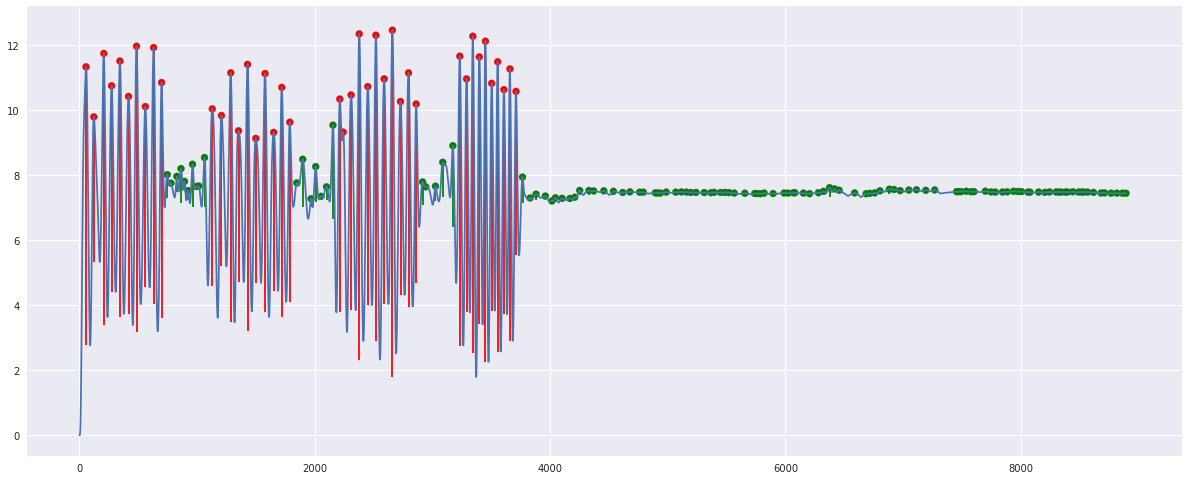

In [592]:
plot_walk_turn_clusters(df.y.values, window=[1, 1, 2])

Great! It seems that we are on track to get this. We can make this even better but will stop optimising for now and continue with separating this into walks and turns.

In [596]:
def separate_walks_turns(data, window=[1, 1, 1]):
    """ Will separate peaks into the clusters by following the trend in the clusters array.
        This is usedful because scipy's k-mean clustering will give us a continous clusters
        array.
        
        :param clusters array: A continous array representing different classes.
        :param peaks array: The peaks that we want to separate into the classes from the custers.
        
        :return walks arrays: An array of arrays that will have all the peaks corresponding to every
                              individual walk.
        :return turns arraays: Array of array which has all the indices of the peaks that correspond
                               to turning.
    
    """
    clusters, peaks, promi = cluster_walk_turn(data, window=window)
    
    group_one = []
    group_two = []
    
    start = 0

    for i in range(1, len(clusters)):
        
        if clusters[i-1] != clusters[i]:
            assert np.all(clusters[start: i] == clusters[start]), 'Some values are mixed up, please check!'
            
            add = group_one if clusters[start] == 0 else group_two
            add.append(peaks[start: i])
            start = i
        
        # hacky fix for the last part of the signal ...
        # I need to change this ...
        if i == len(clusters)-1:
            if not peaks[start] in add[-1]:
                add = group_one if clusters[start] == 0 else group_two
                add.append(peaks[start: ])
                
    maxes_one = [np.max(data[c]) for c in group_one]
    maxes_two = [np.max(data[c]) for c in group_two]
    
    walks, turns = group_two, group_one
    
    if np.max(maxes_one) > np.max(maxes_two):
        walks, turns = group_one, group_two
    
    # let's drop any turns at the end of the signal
#     if len(turns[-1]) > len(walks[-1]):
#         turns.pop()
    
    return walks, turns

In [597]:
walks, turns = separate_walks_turns(df.x.values)

In [598]:
# Let's count some steps from our walks
[len(t) for t in walks]

[10, 10, 11, 11]

In [600]:
def plot_walks_turns(df, window=[1, 1, 1]):
    
    clusters, peaks, promis = cluster_walk_turn(df, window=window)
    walks, turns = separate_walks_turns(df, window=window)
    
    top_of_graph = np.concatenate([df[w] for w in walks]).max()
    contour_heights = df[peaks] - promis
    
    plt.plot(df)
    for w in walks:
        
        plt.plot(w, df[w], 'o')
        plt.text(np.mean(w, dtype=np.int), top_of_graph, len(w), fontsize=22)
        #plt.vlines(x=w, ymin=contour_heights[w], ymax=df[w])

    for t in turns:
        plt.plot(t, df[t], 's')
#         plt.text(np.mean(t, dtype=np.int), top_of_graph, len(t), fontsize=22)
        #plt.vlines(x=t, ymin=contour_heights[t], ymax=df[t])

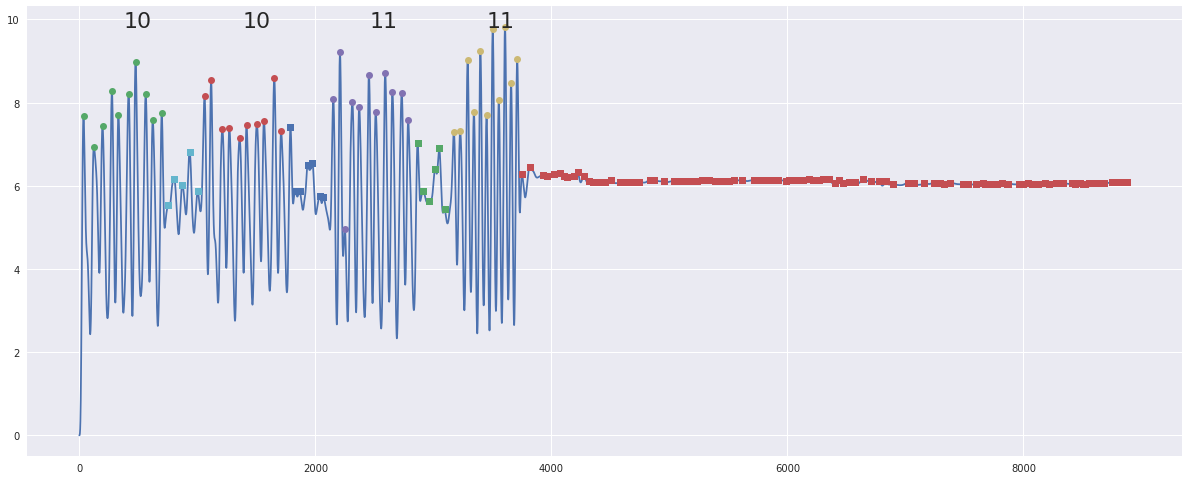

In [601]:
plot_walks_turns(df.x.values)

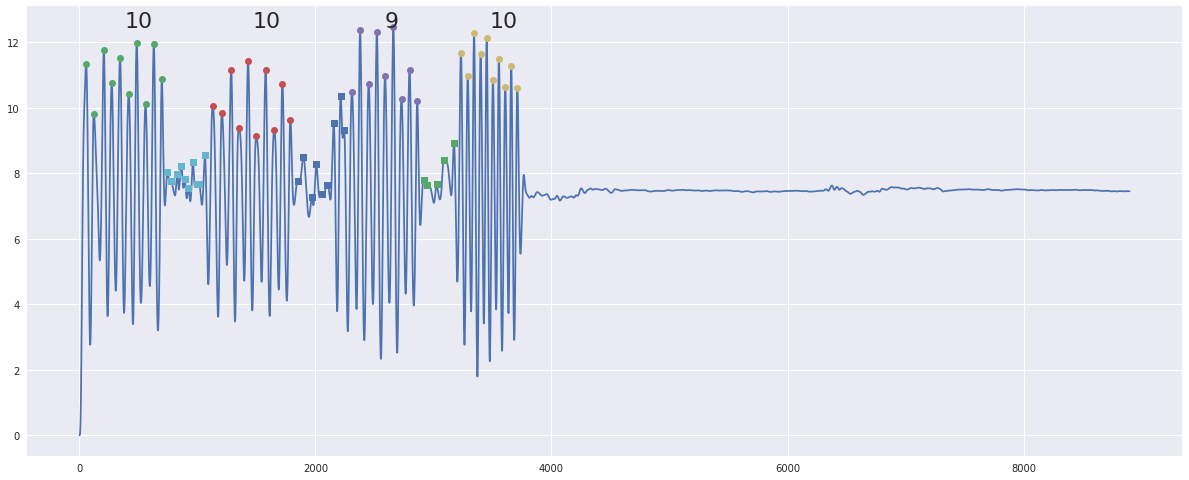

In [554]:
plot_walks_turns(df.y.values)

In [ ]:
plot_walks_turns

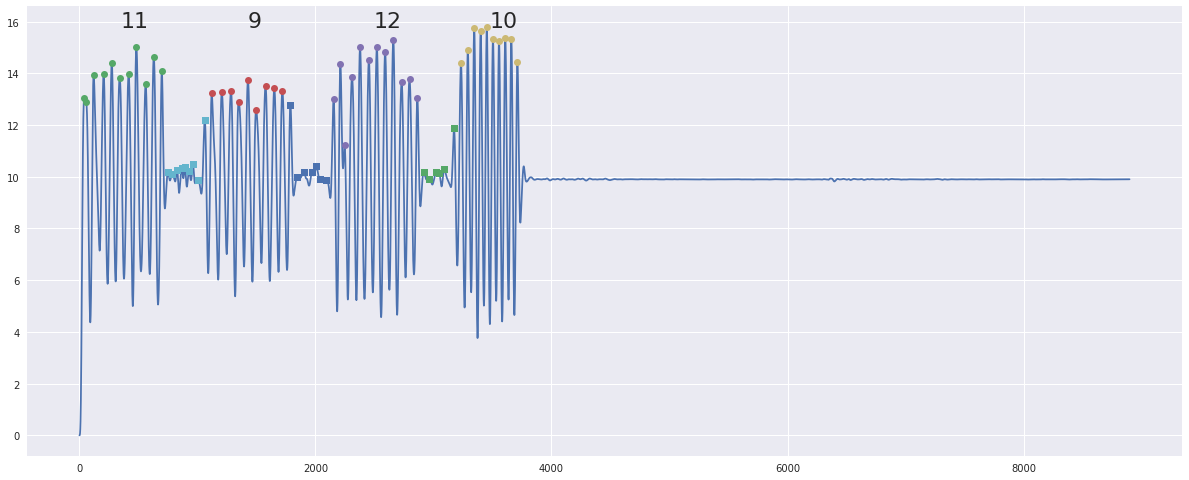

In [556]:
plot_walks_turns(df.mag_sum_acc.values)

## Ok, so far so good... Now let's have a look at gyroscope data!!

We have already applied the lowpass filter to all the dataframe so we can use it.

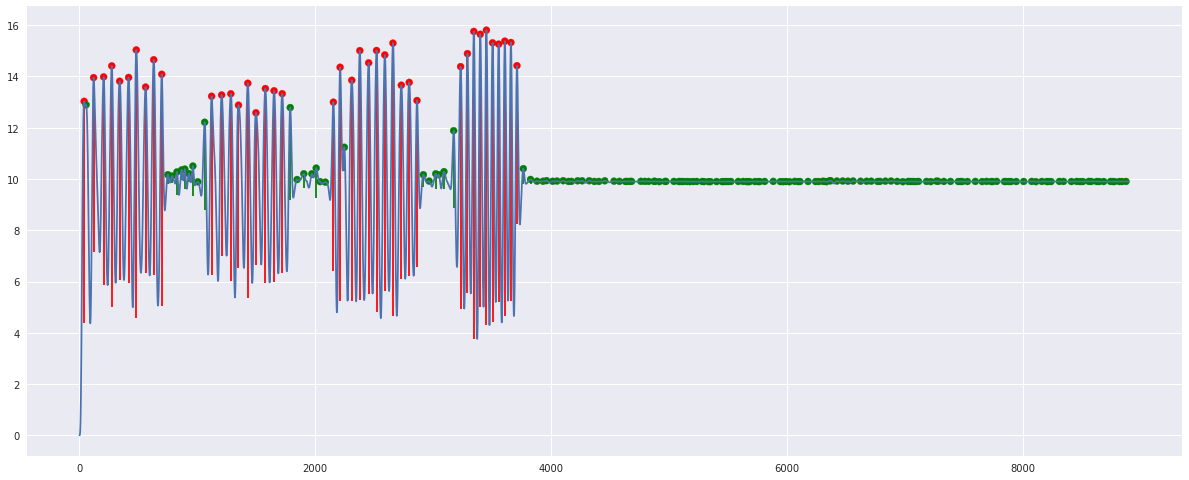

In [549]:
plot_walk_turn_clusters(df.mag_sum_acc.values, window=None)

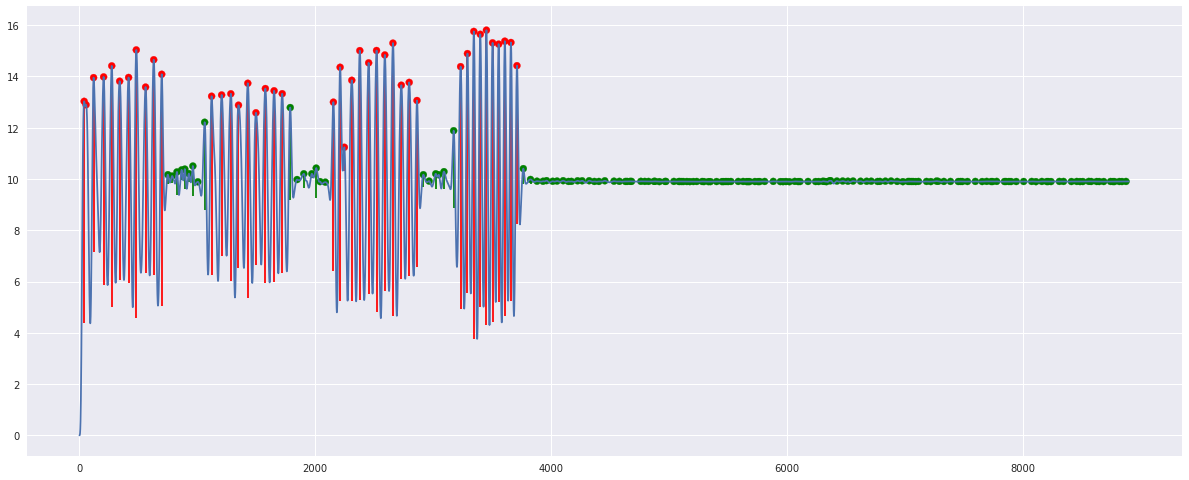

In [553]:
plot_walk_turn_clusters(df.mag_sum_acc.values, window=[1, 1, 1])

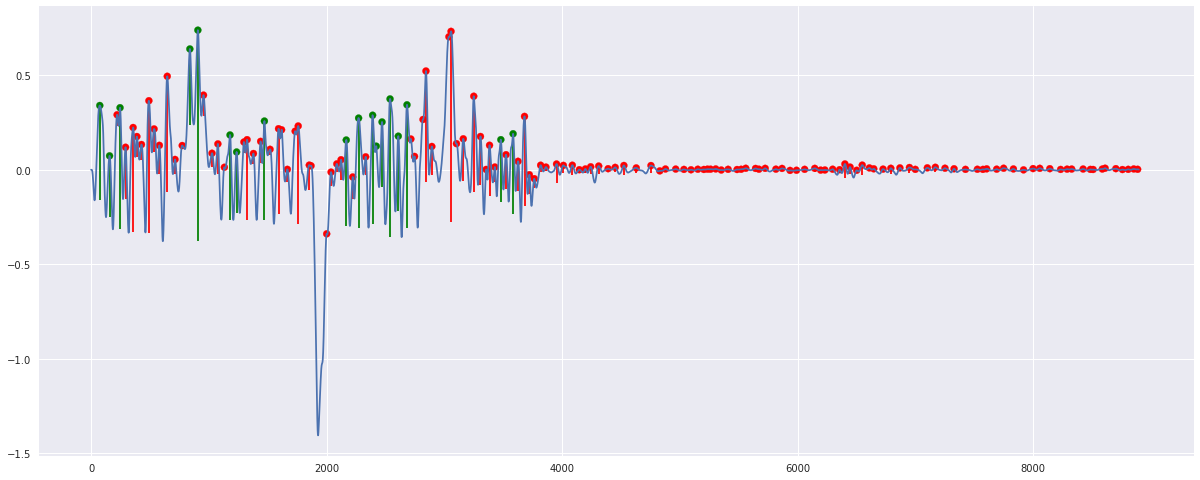

In [114]:
plot_walk_turn_clusters(df.r3.values, window=[1, 1, 2])

Looks like we need a different approach with gyroscope data as the angular momentum exhibits both peaks and valleys. We will look at the euclidean distance between signal extremities (peaks and valleys).

In [115]:
def get_peaks_valleys(data):
    """This will return top and bottom peaks, or peaks tops and valleys bottoms.
        
        :param data array: One-dimensional array.
        
        :return array top: The top peaks (peaks tops).
        :return array bot: The bottom peaks (valleys).
    """
    top = sig.argrelextrema(data, np.greater)[0]
    bot = sig.argrelextrema(data, np.less)[0]
    
    return top, bot

In [165]:
top, bot = get_peaks_valleys(df.r3.values)

In [168]:
diffs = dd[bot] - dd[top]

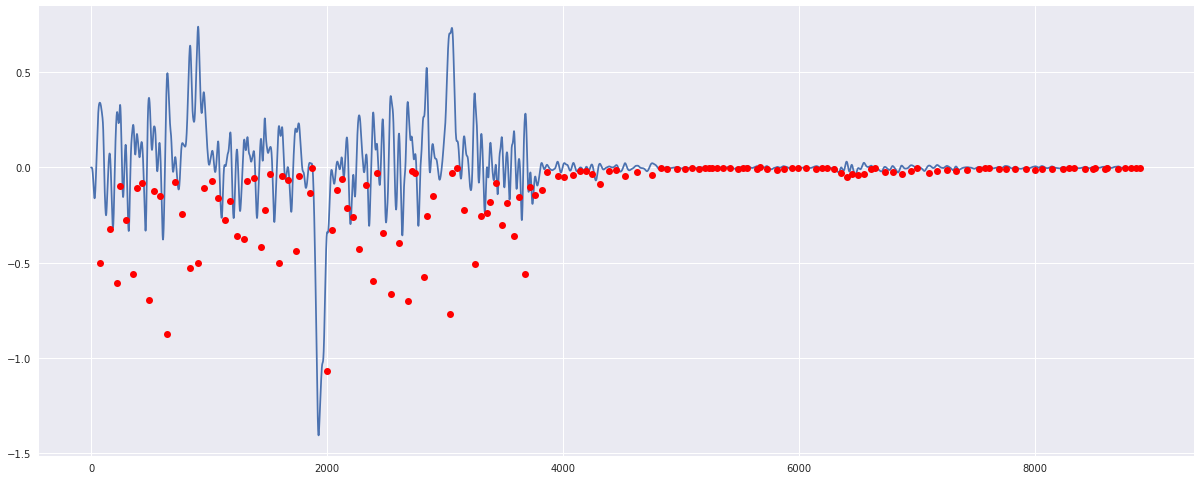

In [212]:
dd = df.r3.values

plt.plot(dd)
plt.plot(top, diffs, 'ro')

Ok, this does not work... After some reading it seems that integrating the gyroscope is the best approach. Integration will get us the current gyroscope angle from the angular velocity.

So we have *angular velocity*:
$$\omega = \frac{\Delta\phi}{\Delta t} = \frac{\phi_{n} - \phi_{n-1}}{t_{n} - t_{n-1}}$$

And the *current angle* can be calculated from the *previous angle*:

$$\phi_n = \phi_{n+1} + \omega\cdot\Delta t$$

In [217]:
import scipy.integrate as I

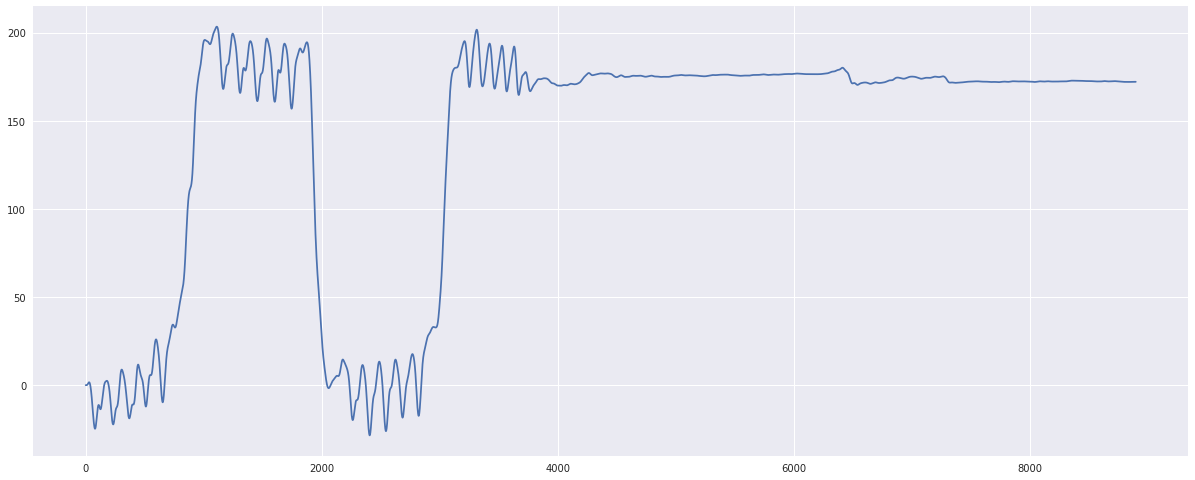

In [278]:
int_r1 = I.cumtrapz(df.r1.values)
plt.plot(int_r1)

Cummulative sum will give us the same result, as the sampling rate is fixed

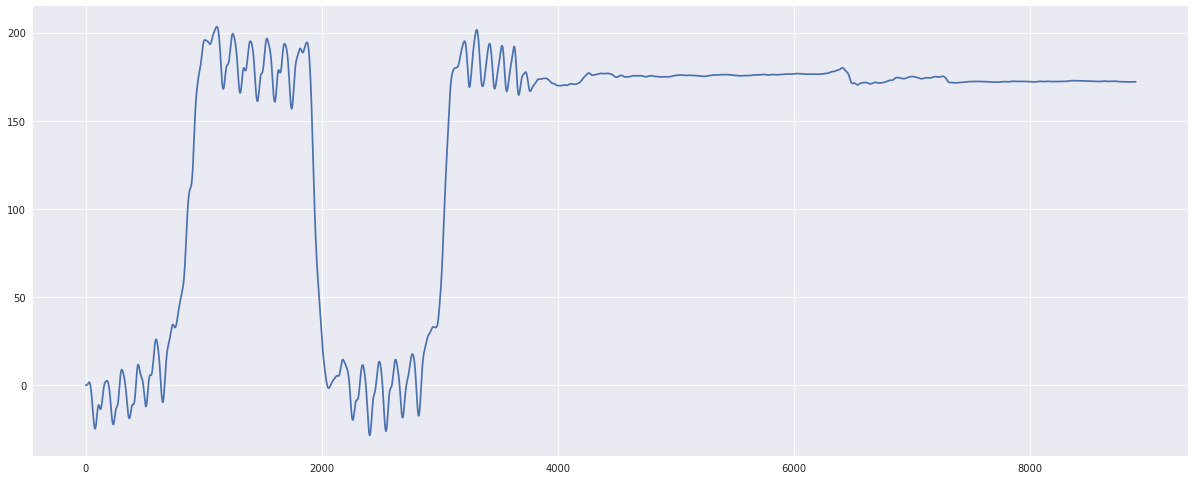

In [279]:
plt.plot(np.cumsum(df.r1.values))

Let's try our prominences clustering algorithm and see if we can separate the turns from the walks.

Just by looking at the plot we can see that it will not be possible as we have turns in different directions and these are translated into valleys, which will not be picked up by the prominences detector.

Another idea would be to flip the Y axis and aggregate the results... but we won't try that...

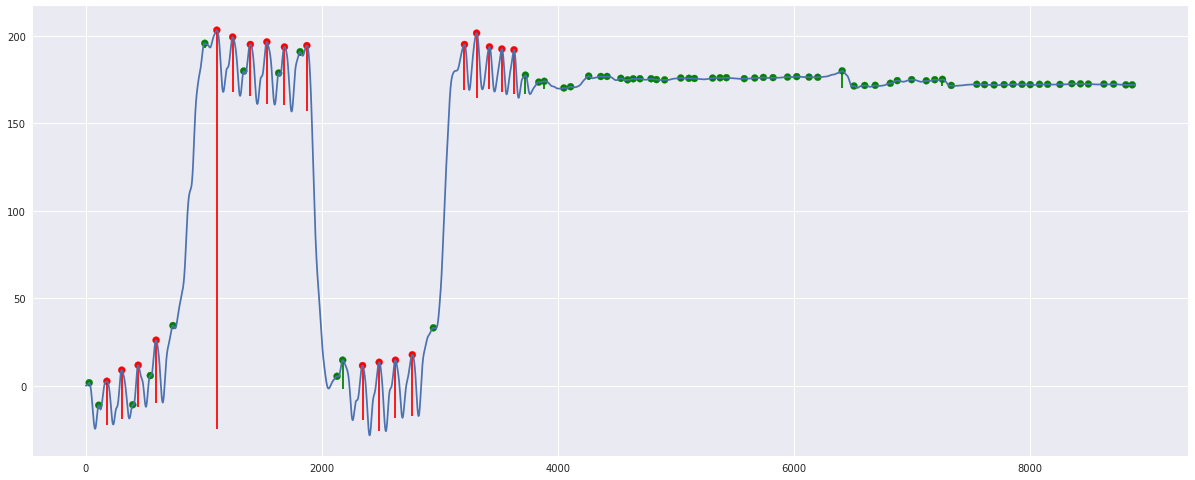

In [282]:
plot_walk_turn_clusters(int_r1, window=None)

Ho about if we look at the distance between peaks? Not top vs bottom peaks, but just the distance between the top peaks!

In [283]:
top, bot = get_peaks_valleys(int_r1)

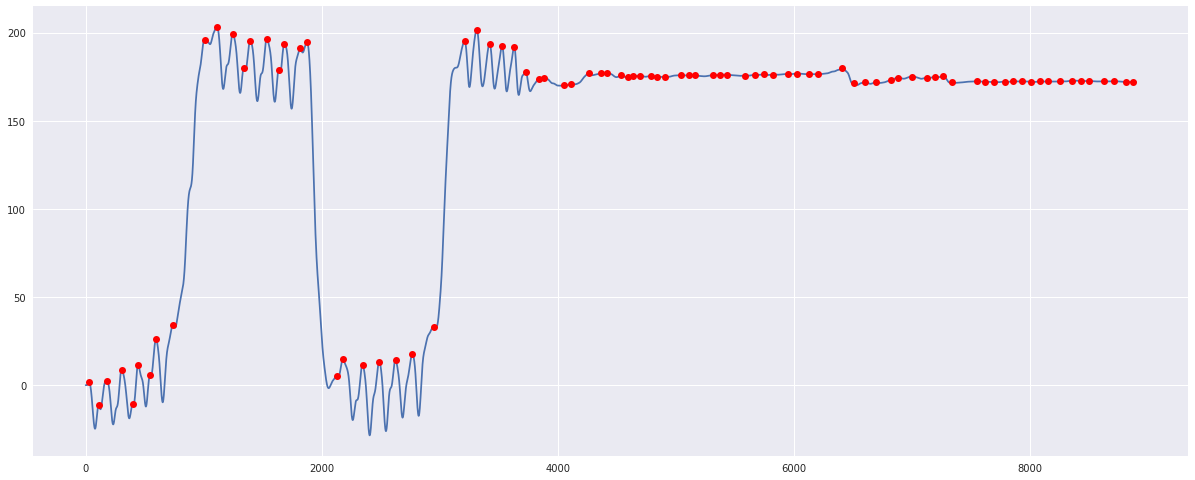

In [285]:
plt.plot(int_r1)
plt.plot(top, int_r1[top], 'ro')
#plt.plot(bot, int_r1[bot], 'go')


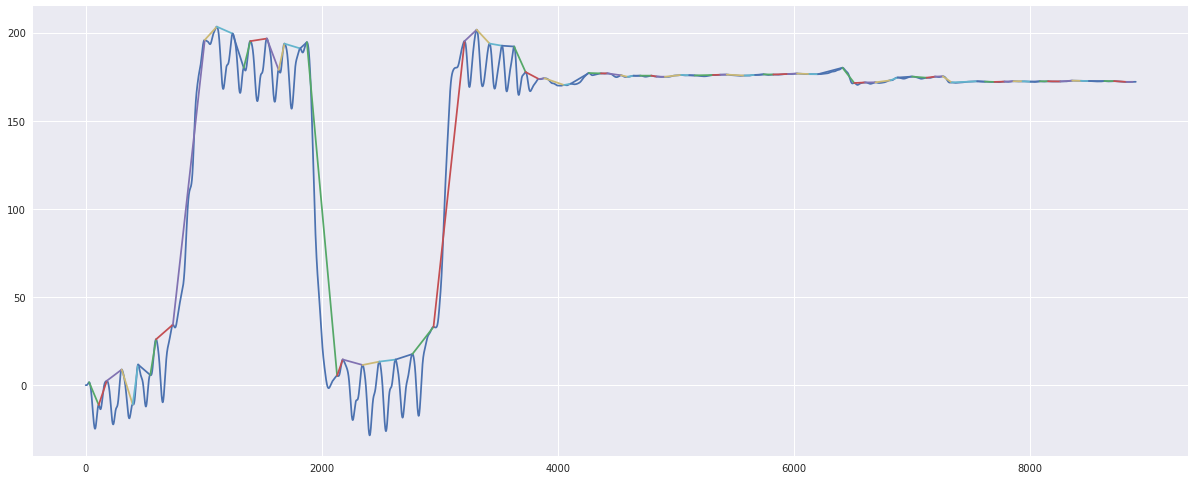

In [426]:
euclidean = []
manhattan = []

plt.plot(int_r1)

for i in range(1, len(top)):
    x1 = top[i-1]
    x2 = top[i]
    
    y1 = int_r1[x1]
    y2 = int_r1[x2]
    
    plt.plot([x1, x2], [y1, y2])
    
    euclidean.append(np.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))
    manhattan.append( np.abs(x2 - x1) + np.abs(y2 - y1) )

In [429]:
def distance_metric(x, y):
    euclidean, manhattan = [], []
    
    for i in range(1, len(x)):
        x1 = x[i-1]
        x2 = x[i]

        y1 = y[x1]
        y2 = y[x2]
        
        euclidean.append(np.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))
        manhattan.append( np.abs(x2 - x1) + np.abs(y2 - y1) )
        
    euclidean = np.array(euclidean)
    manhattan = np.array(manhattan)
    
    return euclidean, manhattan

We are looking at both euclidean and manhattan distance because we would like to know which is more efficient.

Actually the manhattan distance makes more sense to us because we are getting the prominences, so the shortest distance might mess up our algorithm. Nevertheless let's have a look at both and compare.

In [433]:
euclidean, manhattan = distance_metric(top, int_r1)

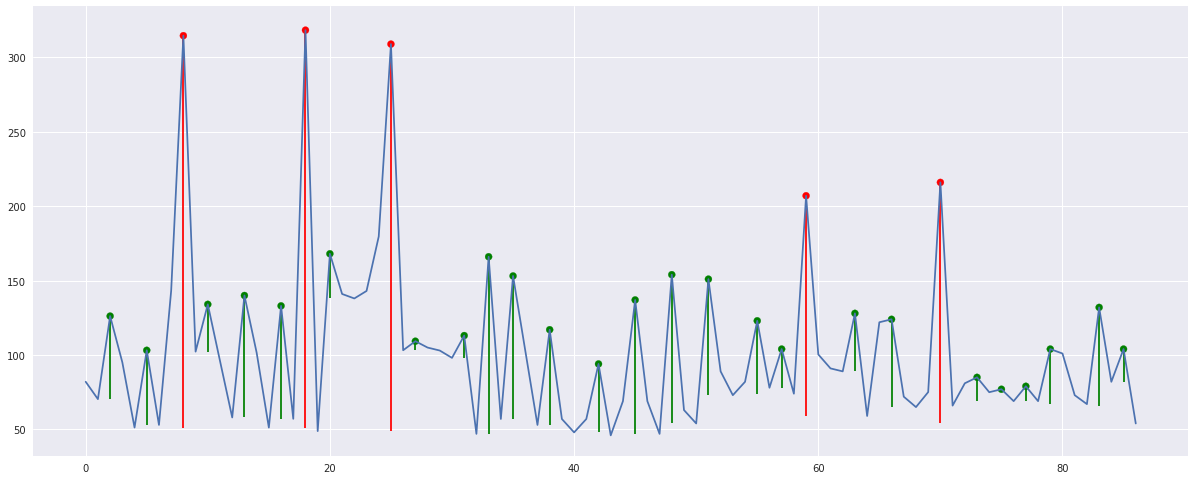

In [434]:
plot_walk_turn_clusters(euclidean, window=None)

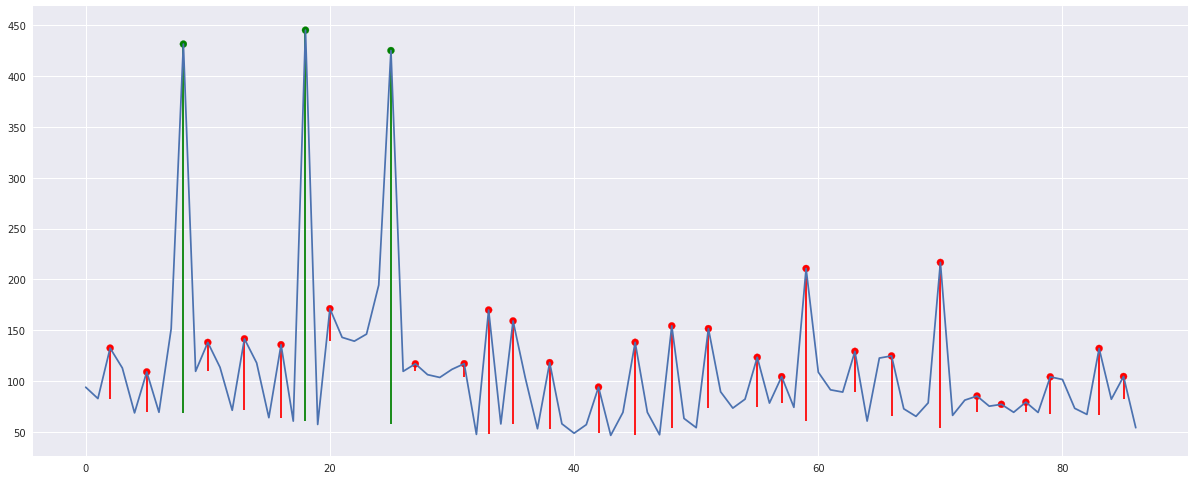

In [435]:
plot_walk_turn_clusters(manhattan, window=None)

In [436]:
c, pk, pr = cluster_walk_turn(manhattan, window=None)

In [437]:
# separate the turns from the walks
classes, counts = np.unique(c, return_counts=1)

In [438]:
turns = np.where(c == classes[np.argmin(counts)])[0]
walks = np.where(c == classes[np.argmax(counts)])[0]
turns, walks

(array([2, 6, 8]),
 array([ 0,  1,  3,  4,  5,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29]))

In [439]:
turn_peaks = pk[turns]
walk_peaks = pk[walks]

#, walk_peaks
walk_peaks, turn_peaks

(array([ 2,  5, 10, 13, 16, 20, 27, 31, 33, 35, 38, 42, 45, 48, 51, 55, 57,
        59, 63, 66, 70, 73, 75, 77, 79, 83, 85]), array([ 8, 18, 25]))

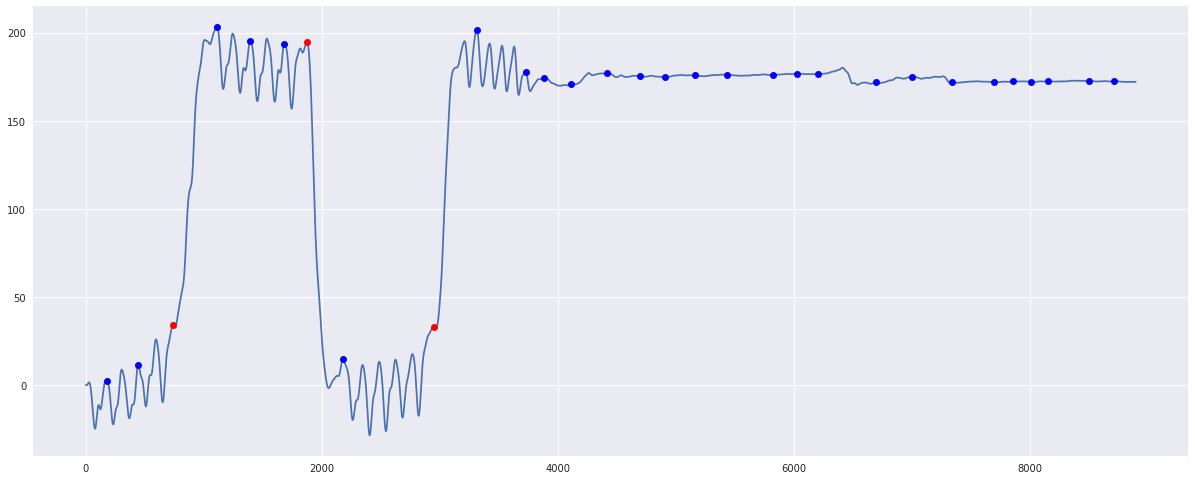

In [440]:
plt.plot(int_r1)
plt.plot(top[turn_peaks], int_r1[top[turn_peaks]], 'ro')
plt.plot(top[walk_peaks], int_r1[top[walk_peaks]], 'bo')

This looks good enough, now we should get the turning and walking sections of the signal...

In [441]:
turn_segment = [[t-1, t, t+1] for t in turn_peaks if t > 0]
turn_segment

[[7, 8, 9], [17, 18, 19], [24, 25, 26]]

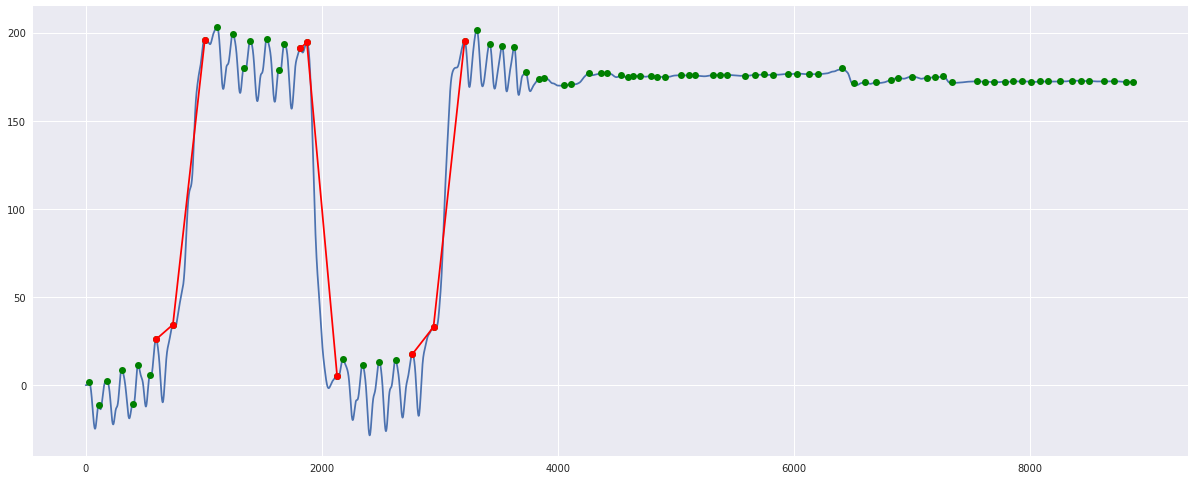

In [490]:
plt.plot(int_r1)
plt.plot(top, int_r1[top], 'go')
for t in turn_segment:
    plt.plot([top[t[0]], top[t[1]]], [int_r1[top[t[0]]], int_r1[top[t[1]]]], 'r')
    plt.plot([top[t[1]], top[t[2]]], [int_r1[top[t[1]]], int_r1[top[t[2]]]], 'r')
    plt.plot(top[t], int_r1[top[t]], 'ro')

Ok, we need to get the turning segment and separate the data into turns and walks.

In [472]:
turn_star_end = []

for t in turn_segment:
    x = top[t]
    y = int_r1
    _, man = distance_metric(x, y)
    
    # we use :2 beucase we have only 3 elements in each turn_segment
    # if the last distance is the longest we will use 1:.
    longer_segment = t[:2]
    if np.argmax(man):
        longer_segment = t[1:]
    
    turn_star_end.append(longer_segment)

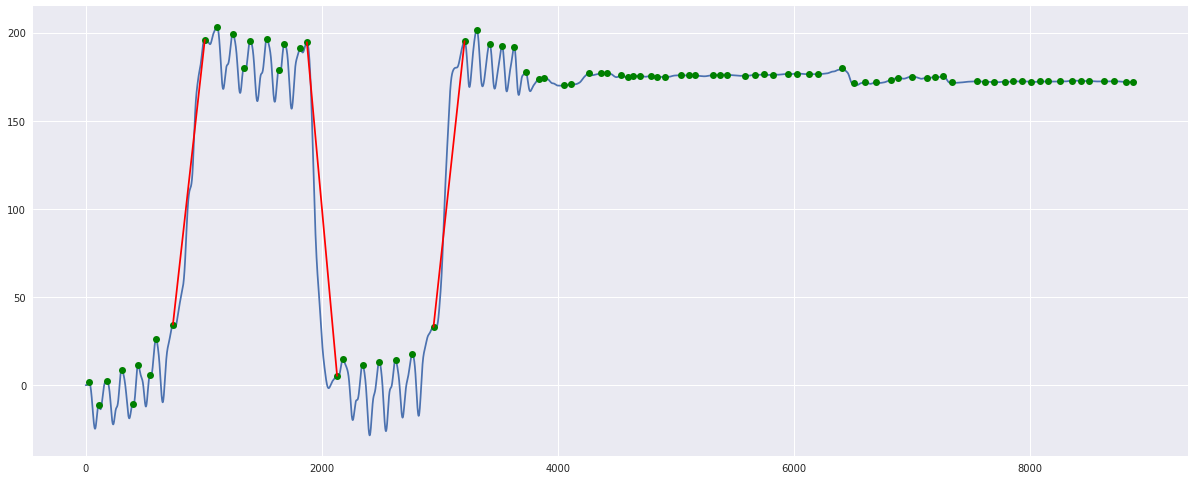

In [497]:
plt.plot(int_r1)
plt.plot(top, int_r1[top], 'go')
for t in turn_star_end:
    plt.plot([top[t[0]], top[t[1]]], [int_r1[top[t[0]]], int_r1[top[t[1]]]], 'r')

In [498]:
top

array([  29,  110,  179,  305,  398,  444,  547,  596,  739, 1009, 1111,
       1245, 1339, 1395, 1535, 1635, 1684, 1817, 1874, 2130, 2178, 2346,
       2487, 2625, 2768, 2947, 3210, 3313, 3422, 3527, 3630, 3727, 3840,
       3887, 4053, 4110, 4263, 4366, 4419, 4536, 4593, 4641, 4698, 4792,
       4838, 4907, 5044, 5113, 5160, 5314, 5377, 5431, 5582, 5671, 5744,
       5826, 5949, 6027, 6131, 6205, 6412, 6512, 6603, 6692, 6820, 6879,
       7001, 7125, 7197, 7262, 7337, 7553, 7619, 7700, 7785, 7860, 7937,
       8006, 8085, 8154, 8258, 8359, 8432, 8499, 8631, 8713, 8817, 8871])

In [534]:
the_walks = []

for i, t in enumerate(turn_star_end):
    if not i:
        walk = [top < top[t[0]]]
        turn_stop  = t[1]
    else:
        walk = ( ( top > top[turn_stop]  ) & (top < top[t[0]]) ) 
        turn_stop  = t[1]
        
    the_walks.append( top[walk] )
    
    if i == len(turn_star_end) - 1:
        walk = ( ( top > top[t[0]]  ) )
        
        the_walks.append( top[walk] )

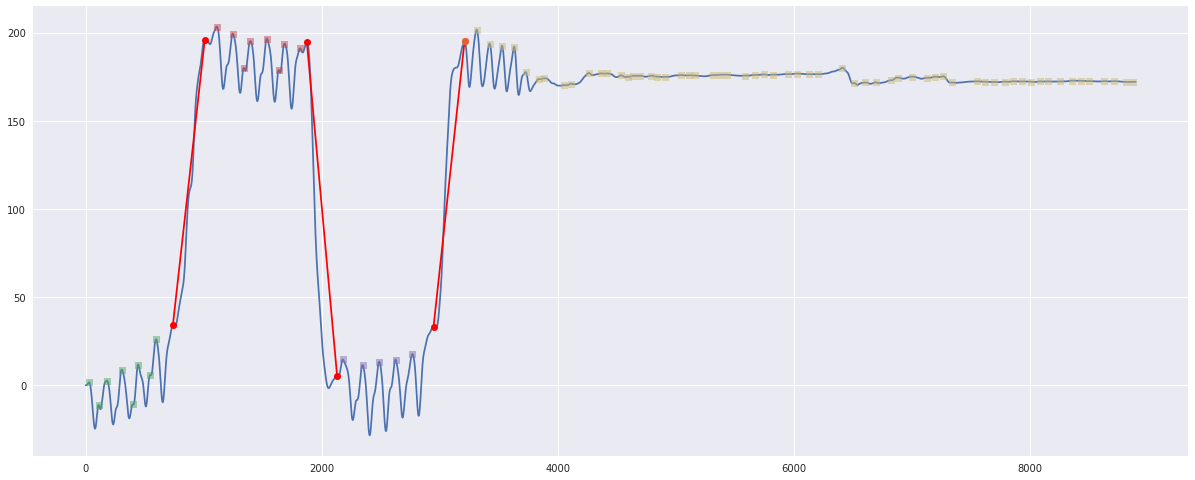

In [535]:
plt.plot(int_r1)

for t in turn_star_end:
    plt.plot([top[t[0]], top[t[1]]], [int_r1[top[t[0]]], int_r1[top[t[1]]]], 'r')
    plt.plot(top[t], int_r1[top[t]], 'ro')

for w in the_walks:
    plt.plot(w, int_r1[w], 's', alpha=0.5)

Ok, it seems that we have separated the turns from the walks using gyroscope data. We still need to figure out when the walking stops in the last segment.

#### Stuff to test:

- Implement a complementary filter
- Kalaman filter on the azimuthal coordinates
- Kalaman filter on the quaternions

#### Some interesting resources:

- [Nice overview of filters](http://portal.ts-muenchen.de/Dateien/filter.pdf)
- [Interesting paper on Kalaman filters efficiency in a VR setting](https://stanford.edu/class/ee267/Spring2016/report_cornman_mei.pdf)
- [Book on Kalaman and Bayesian filters](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python)